# DDPG + PPO cooperation :: re-wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from task import Task, update_goal_curyctor
from alchemy.bot import Bot, BrainDescription
from alchemy.env import Env

from utils.crossexp import *

from utils.encoders import *
from utils.rnn import *
import model

from utils.replay import ReplayBuffer

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config ( trough .toml and all in one place, lot is now in 5th cell )

In [2]:
TOTAL_ENV = 20
STATE_SIZE = 33 - 3
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#

N_REWARDS = 9
N_ACTORS = 1
MAX_STEPS = 70

### 3. Setup dummies ( unused feats in this environment )

In [3]:
class RandPrio: # for prio replay, but we abandon that for now
    def weight(self, s, n, a):
        return np.asarray([random.random() for _ in range(a.reshape(-1).shape[0])]).reshape(a.shape)

    def update(self, s, n, a):
        pass

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)

### 4. Set model wrappers

In [4]:
def Actor(encoder, ddpg=True):
    nes_layers = [encoder.out_size(), 400, 300, ACTION_SIZE]
    action_fn = lambda x: torch.tanh(x) * (3. if ddpg else 1.)
    return lambda: model.ActorFactory(nes_layers, action_fn, action_size=ACTION_SIZE, ddpg=ddpg)

def Critic(encoder):
    return lambda: model.Critic(N_ACTORS, N_REWARDS, encoder.out_size(), ACTION_SIZE, lambda x: x)

def callback(bot, task, test_scores, learn_scores, seeds, total):
    if 0 == total % 4:
        # OK we move DDPG towards PPO safe zone
        bot.sync_explorer(0, 1, [])
        bot.sync_target(0, 1, [])
        # NOW we move PPO towards wilder DDPG exploration
        bot.sync_explorer(1, 0, [])
        bot.sync_target(1, 0, [])
    if test_scores is not None:
        print("\n\t==> test round with ", len(test_scores), test_scores, np.mean(learn_scores))
        
def debugout(bot, scores, actions):
    pass

### 5. Setup && run agent/bot

In [5]:
PPO_LOOP = 2
bs = 2048
learning_delay = MAX_STEPS * PPO_LOOP

ppo_n_envs = 14 # rest ( 6 ) ddpg for driving exploration beyond safe zone
ddpg_n_envs = TOTAL_ENV - ppo_n_envs # rest will be PPO for estimating safe zone to go
    
#rand_prio = RandPrio()

ReplayBuffer = cross_exp_buffer(TOTAL_ENV*250) # without need to recalc feats again and again, aka small one

replay_ppo = ReplayBuffer(
            n_step=N_STEP, replay_reanalyze=True,
            buffer_size=learning_delay * ppo_n_envs * 2, select_count=40, max_ep_draw_count=40,
            alpha=.7, beta_base=.3, beta_end=.7, beta_horizon=10000,
            recalc_delta=3, share_exp_ratio=0)

replay_ddpg = ReplayBuffer(
            n_step=N_STEP, replay_reanalyze=True,
            buffer_size=MAX_STEPS * ddpg_n_envs * 100, select_count=4, max_ep_draw_count=40,
            alpha=.7, beta_base=.3, beta_end=.7, beta_horizon=10000,
            recalc_delta=3, share_exp_ratio=4)

encoder = Encoder()
brain_descriptions = [
        BrainDescription( # master :: DDPG
            ddpg=True,
            count=ddpg_n_envs, n_groups=ddpg_n_envs, Actor=Actor(encoder), Critic=Critic(encoder),
            model_path="x_coop_v2_checkpoints", save=True, load=True, delay=1,
            resample_delay=N_STEP,
            good_reach=1, replay_buffer=replay_ddpg, batch_size=128,
            sync_delta=5, learning_delay=N_STEP * 3, learning_repeat=TOTAL_ENV * 5,
            fresh_frac=10, optim_epochs=3,
            ppo_eps=None, dbgout=False,
            adv_on=True, adv_boost=False,
            lr_actor=2e-4, lr_critic=2e-4, clip_norm=5.,
            tau_replay_counter=40 * 2*TOTAL_ENV*5, tau_base=1., tau_final=1e-3,
            replay_cleaning=False, prob_treshold=None),
        BrainDescription( # shadow :: PPO
            ddpg=False,
            count=ppo_n_envs, n_groups=ppo_n_envs, Actor=Actor(encoder, False), Critic=Critic(encoder),
            model_path="x_coop_v2_checkpoints", save=True, load=True, delay=1,
            resample_delay=N_STEP,
            good_reach=1, replay_buffer=replay_ppo, batch_size=bs,
            sync_delta=3, learning_delay=learning_delay, learning_repeat=TOTAL_ENV * 10,
            fresh_frac=10, optim_epochs=3,
            ppo_eps=2e-1, dbgout=False,
            adv_on=True, adv_boost=False,
            lr_actor=2e-4, lr_critic=2e-4, clip_norm=5.,
            tau_replay_counter=50*5*TOTAL_ENV, tau_base=1., tau_final=1e-2,
            replay_cleaning=True, prob_treshold=(7e-3, 1.7)),
    ]

bot = Bot(
# brain configs
        encoder,
        brain_descriptions,

        n_actors=2, n_critics=1,
        n_history=N_HISTORY, state_size=STATE_SIZE, action_size=ACTION_SIZE,
        n_step=N_STEP, floating_step=True, gamma=.99,

# agent configs
        update_goal=update_goal_curyctor(N_STEP),
        her_max_ratio=1,
        gae=True, gae_tau=.95,
        freeze_delta=10, freeze_count=6,
        )

task = Task()

env = Env(bot, task,
        total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
        n_step=N_STEP, send_delta=N_STEP * 3,
        eval_limit=10, eval_ratio=.5, max_n_episode=MAX_STEPS, eval_delay=20,
        mcts_random_cap=1000, mcts_rounds=1)

bot.sync_explorer(1, 0, [])
bot.sync_target(1, 0, [])

scores = env.start(callback, debugout)
losses_1 = bot.brains[0].get_losses()
losses_2 = bot.brains[1].get_losses()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


[    2>   110:: 0] steps =   39, max_step =  71/ 70, reward=-0.042611 <action=[ 0.60063045  0.51593575 -0.2946079  -0.19042786]>                    

C:\Users\qilin\Desktop\breaktrough\rewheeler\alchemy\agent.py:163: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  batch = np.vstack(zip(*self._regroup_for_replay()))
C:\Users\qilin\Desktop\breaktrough\rewheeler\alchemy\agent.py:201: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack(zip(*batch))
C:\Users\qilin\Desktop\breaktrough\rewheeler\utils\policy.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  td_error = torch.tensor(td_targets).to(qa.device) - qa


[   20>  1419:: 0] steps =   70, max_step =  71/ 70, reward=0.049222 <action=[-0.21554573 -2.99997993 -2.95657863 -2.69326781]>                                    
	==> test round with  1 [3.534999920986581] 0.05005555555555555
[   40>  2839:: 0] steps =   70, max_step =  71/ 70, reward=0.058611 <action=[ 2.99951027 -2.55889208 -0.88375466 -2.97346807]>                     
	==> test round with  1 [3.7204999168403274] 0.05966666666666667
[   60>  4259:: 0] steps =   70, max_step =  71/ 70, reward=0.066722 <action=[ 0.29677132 -2.92528167  2.98547884  2.72155744]>                                     
	==> test round with  1 [4.275499904435126] 0.06772222222222224
[   80>  5679:: 0] steps =   70, max_step =  71/ 70, reward=0.070000 <action=[ 1.4827703   1.21955247  2.99998726 -2.99991641]>                                     
	==> test round with  1 [6.827999847382324] 0.0708888888888889
[  100>  7099:: 0] steps =   70, max_step =  71/ 70, reward=0.078111 <action=[-3.          3.        

In [6]:
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex_1 = losses_1
losses_1 = np.vstack(losses_1)[::len(losses_1)//200]
losses_ex_2 = losses_2
losses_2 = np.vstack(losses_2)[::len(losses_2)//200]

### 4. Plot reward + loss

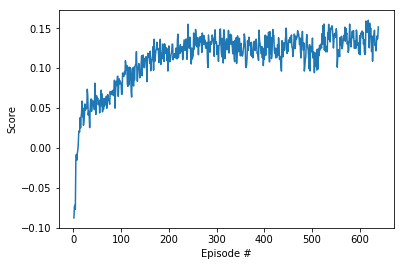

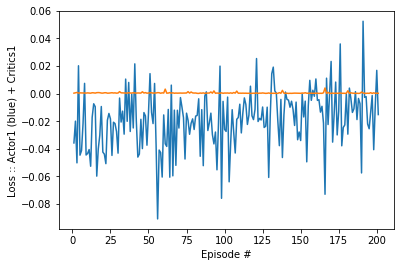

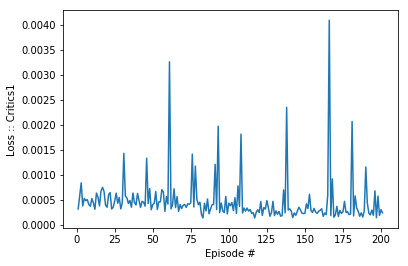

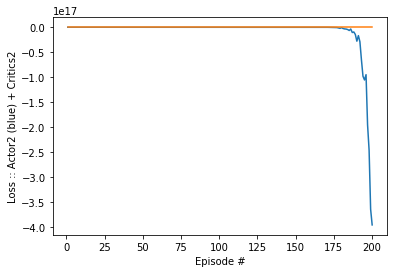

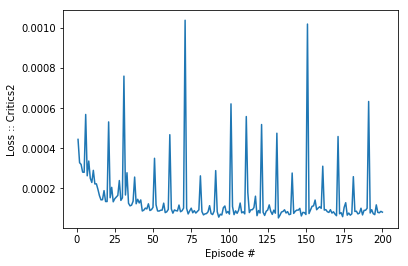

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_1)+1), losses_1)
plt.ylabel('Loss :: Actor1 (blue) + Critics1')
plt.xlabel('Episode #')
plt.show() 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_1)+1), losses_1[:, 1:])
plt.ylabel('Loss :: Critics1')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_2)+1), losses_2)
plt.ylabel('Loss :: Actor2 (blue) + Critics2')
plt.xlabel('Episode #')
plt.show() 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_2)+1), losses_2[:, 1:])
plt.ylabel('Loss :: Critics2')
plt.xlabel('Episode #')
plt.show() 

### 4. Reload trained agent

In [8]:
for i in range(2):
    bot.sync_target(i, i, [])
    bot.sync_explorer(i, i, [])

### 5. Test visuals - TARGET


 environment solved!  31.31144930013456
[31.21999930217865, 32.79349926700823, 32.27399927861984, 31.20449930252503, 30.49899931829423, 31.996499284822484, 31.519499295484277, 30.025999328866607, 31.511999295651936, 30.069499327894285]

 environment solved!  30.8737993099168
[30.508999318070764, 29.80549933379515, 32.36399927660824, 33.032499261666146, 30.64149931510912, 30.771999312192193, 30.46299931909888, 32.26249927887691, 29.397999342903503, 29.48999934084712]

 environment solved!  30.770049312235777
[30.254999323748052, 29.874499332252825, 31.45349929695952, 30.547999317198965, 30.528499317634857, 31.893499287124698, 31.802499289158774, 31.506499295774884, 29.385499343182854, 30.452999319322394]

 environment solved!  30.797899311613275
[31.74199929051099, 28.364999365992798, 32.86849926533177, 30.791499311756343, 30.460999319143575, 29.81149933366102, 30.58599931634959, 31.859999287873492, 29.57849933886899, 31.914999286644168]

 environment solved!  31.3450992993824
[30.3744

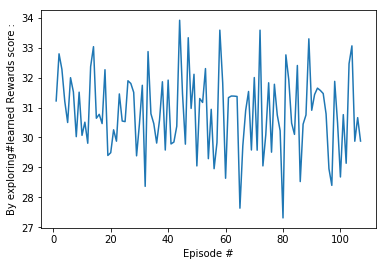

In [9]:
rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 6. Test visuals - EXPLORER ( target network )

mean rewards :  28.6215943602575


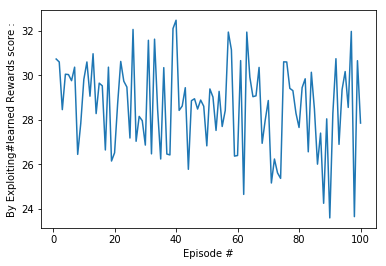

In [10]:
# for evaluation we will set target network to be explorer
bot.brains[0].ac_target = bot.brains[1].ac_target

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By Exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 

### 7. Test visuals - EXPLORER ( explorer network )

mean rewards :  27.944594375389634


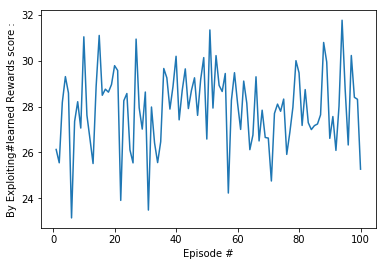

In [11]:
# for evaluation we will set target network to be explorer
bot.brains[0].ac_target = bot.brains[1].ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By Exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 